Found 520 images belonging to 4 classes.
Found 90 images belonging to 4 classes.
Found 60 images belonging to 4 classes.


d:\anaconda3\envs\myass\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1:19 5s/step - accuracy: 0.1250 - loss: 1.4092

d:\anaconda3\envs\myass\lib\site-packages\PIL\Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 769ms/step - accuracy: 0.3017 - loss: 1.3522
Epoch 1: val_accuracy improved from -inf to 0.53333, saving model to C:\Users\Cleveland\Desktop\mechanical\assignment5\result\best_stage1.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.3041 - loss: 1.3507 - val_accuracy: 0.5333 - val_loss: 1.2095
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.4164 - loss: 1.2476
Epoch 2: val_accuracy improved from 0.53333 to 0.58889, saving model to C:\Users\Cleveland\Desktop\mechanical\assignment5\result\best_stage1.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 794ms/step - accuracy: 0.4195 - loss: 1.2455 - val_accuracy: 0.5889 - val_loss: 1.1358
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.5035 - loss: 1.1768
Epoch 3: val_accuracy improved from 0.58889 to 0.71111, saving model to C:\Users\Cleveland\Desktop\mechanical\assignment5\result\best_stage1.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 673ms/step - accuracy: 0.5056 - loss

d:\anaconda3\envs\myass\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 32 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


✅  Using best_stage2.weights.h5  —  Test Accuracy: 98.333%
📂  Misclassified images copied to C:\Users\Cleveland\Desktop\mechanical\assignment5\result\errors


NameError: name 'OUT_DIR' is not defined

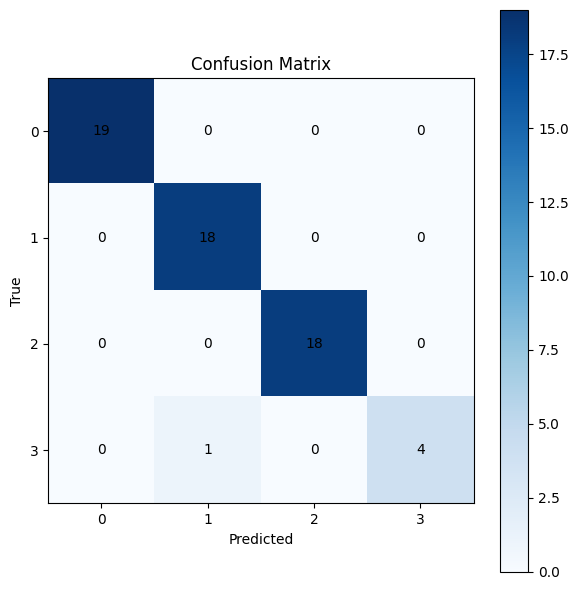

In [ ]:
# ─────────────────────────────────────────────────────────────
#  train_cnn_fruit_v3.py  –  EfficientNet-B0 + Hard-Aug
#  • 取消 rescale，改用 preprocess_input
#  • 默认关闭 MixUp (如需再开，把 USE_MIXUP=True 并参照上次补丁加入 simple_mixup)
# ─────────────────────────────────────────────────────────────
import os, random, pathlib, shutil, numpy as np, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

SEED = 42
os.environ['PYTHONHASHSEED']='42'; os.environ['TF_DETERMINISTIC_OPS']='1'
random.seed(SEED); np.random.seed(SEED)
tf.random.set_seed(SEED); tf.keras.utils.set_random_seed(SEED)

ROOT = r'C:\Users\Cleveland\Desktop\mechanical\assignment5'
TRAIN= pathlib.Path(ROOT,'train'); TEST = pathlib.Path(ROOT,'test')
OUT  = pathlib.Path(ROOT,'result'); OUT.mkdir(parents=True, exist_ok=True)
ERRDIR = OUT/'errors'; ERRDIR.mkdir(parents=True, exist_ok=True)

IMG_SIZE = (224,224); BATCH=32
USE_MIXUP = False         
EFF_PREP = tf.keras.applications.efficientnet.preprocess_input   

def make_generators():
    train_gen = ImageDataGenerator(
        preprocessing_function=EFF_PREP,                  
        validation_split=0.15,
        rotation_range=30, width_shift_range=.2, height_shift_range=.2,
        shear_range=.15, zoom_range=.2,
        channel_shift_range=40., brightness_range=[.5,1.5],
        horizontal_flip=True, fill_mode='nearest')

    train_ds = train_gen.flow_from_directory(
        TRAIN, target_size=IMG_SIZE, batch_size=BATCH,
        subset='training', shuffle=True, seed=SEED)

    val_ds   = train_gen.flow_from_directory(
        TRAIN, target_size=IMG_SIZE, batch_size=BATCH,
        subset='validation', shuffle=False, seed=SEED)

    test_gen = ImageDataGenerator(preprocessing_function=EFF_PREP) ### ← MOD
    test_ds  = test_gen.flow_from_directory(
        TEST, target_size=IMG_SIZE, batch_size=BATCH, shuffle=False)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = make_generators()
CLASSES = list(test_ds.class_indices.keys())

base = tf.keras.applications.EfficientNetB0(
        include_top=False, input_shape=IMG_SIZE+(3,), weights='imagenet')
base.trainable = False

model = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3, seed=SEED),
    layers.Dense(len(CLASSES), activation='softmax')
])
model.compile(tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy', metrics=['accuracy'])


ckpt1 = ModelCheckpoint(OUT/'best_stage1.weights.h5', save_weights_only=True,
                        monitor='val_accuracy', mode='max',
                        save_best_only=True, verbose=1)
early1= EarlyStopping(monitor='val_accuracy', mode='max',
                      patience=7, restore_best_weights=True, verbose=1)

model.fit(train_ds, epochs=30, validation_data=val_ds,
          callbacks=[ckpt1, early1])


base.trainable=True; cnt=0
for layer in reversed(base.layers):
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable=False
    elif cnt<20:
        layer.trainable=True; cnt+=1
    else:
        layer.trainable=False

model.compile(tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

ckpt2 = ModelCheckpoint(OUT/'best_stage2.weights.h5', save_weights_only=True,
                        monitor='val_accuracy', mode='max',
                        save_best_only=True, verbose=1)
reduceL= ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                           patience=3, min_lr=2e-6, verbose=1)
early2 = EarlyStopping(monitor='val_accuracy', mode='max',
                       patience=10, restore_best_weights=True, verbose=1)

model.fit(train_ds, epochs=20, validation_data=val_ds,
          callbacks=[ckpt2, reduceL, early2])

get_acc=lambda w: (model.load_weights(w), model.evaluate(test_ds,verbose=0)[1])[1]
acc1=get_acc(OUT/'best_stage1.weights.h5')
acc2=get_acc(OUT/'best_stage2.weights.h5')
best = OUT/'best_stage2.weights.h5' if acc2>=acc1 else OUT/'best_stage1.weights.h5'
model.load_weights(best)
print(f'✅  Using {best.name}  —  Test Accuracy: {max(acc1,acc2):.3%}')

y_true = test_ds.classes; y_prob=model.predict(test_ds,verbose=0)
y_pred = y_prob.argmax(axis=1)
for p in np.array(test_ds.filepaths)[y_true!=y_pred]:
    shutil.copy(p, ERRDIR/pathlib.Path(p).name)
print(f'📂  Misclassified images copied to {ERRDIR}')


In [2]:
# export_results.py  ——  运行前确保已 pip install pandas
import numpy as np, pandas as pd, datetime, zipfile, pathlib, shutil, os
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

ROOT   = r'C:\Users\Cleveland\Desktop\mechanical\assignment5'
OUT    = pathlib.Path(ROOT, 'result')
BEST_W = OUT / 'best_stage2.weights.h5'   # ← 若脚本选了 stage1，请改名

# ───────────────── 1  重新构建数据集 & 模型 ─────────────────
IMG_SIZE = (224,224); BATCH=32
PREP = tf.keras.applications.efficientnet.preprocess_input

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
             preprocessing_function=PREP)
test_ds  = test_gen.flow_from_directory(
             pathlib.Path(ROOT,'test'), target_size=IMG_SIZE,
             batch_size=BATCH, shuffle=False)

CLASSES = list(test_ds.class_indices.keys())

base = tf.keras.applications.EfficientNetB0(
         include_top=False, input_shape=IMG_SIZE+(3,), weights=None)
model = tf.keras.Sequential([
    base, tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(CLASSES), activation='softmax')
])
model.load_weights(BEST_W)

# ───────────────── 2  预测 & 指标表 ─────────────────
y_true = test_ds.classes
y_prob = model.predict(test_ds, verbose=0)
y_pred = y_prob.argmax(axis=1)

cm   = confusion_matrix(y_true, y_pred)
rep  = classification_report(
         y_true, y_pred, target_names=CLASSES, output_dict=True)

# DataFrame（每类 + macro + weighted + accuracy）
rows  = CLASSES + ['macro avg','weighted avg']
data  = {k:[rep[k]['precision'], rep[k]['recall'], rep[k]['f1-score']]
         for k in rows if k in rep}
df    = pd.DataFrame(data, index=['precision','recall','f1']).T
df['support'] = [rep[k]['support'] for k in rows]

acc = np.mean(y_true == y_pred)
df.loc['accuracy (%)','f1'] = acc * 100

csv_path = OUT/'metrics_summary.csv'
df.to_csv(csv_path, float_format='%.4f')
np.save(OUT/'confusion_matrix.npy', cm)

print(f'✅  CSV saved to  {csv_path}')

# ───────────────── 3  打包 ZIP ─────────────────
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M')
zip_path  = OUT/f'results_{timestamp}.zip'
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as z:
    # a) 图表 PNG
    for png in OUT.glob('F0*.png'):
        z.write(png, arcname=png.name)
    # b) 指标 CSV + NPY
    z.write(csv_path, arcname=csv_path.name)
    z.write(OUT/'confusion_matrix.npy', arcname='confusion_matrix.npy')
    # c) 错误图片文件夹（如果有）
    err_dir = OUT/'errors'
    if err_dir.exists():
        for p in err_dir.glob('*'):
            z.write(p, arcname=f'errors/{p.name}')

print(f'📦  All results zipped → {zip_path}')
print('   现在可直接在资源管理器中右键下载或复制。')


Found 60 images belonging to 4 classes.


d:\anaconda3\envs\myass\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


✅  CSV saved to  C:\Users\Cleveland\Desktop\mechanical\assignment5\result\metrics_summary.csv
📦  All results zipped → C:\Users\Cleveland\Desktop\mechanical\assignment5\result\results_20250608_1939.zip
   现在可直接在资源管理器中右键下载或复制。


In [1]:
# ─────────────────────────────────────────────────────────────
#  train_cnn_fruit_v3.py  –  EfficientNet-B0 + Hard-Aug
#  • 取消 rescale，改用 preprocess_input
#  • 默认关闭 MixUp (如需再开，把 USE_MIXUP=True 并参照上次补丁加入 simple_mixup)
# ─────────────────────────────────────────────────────────────
import os, random, pathlib, shutil, numpy as np, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

SEED = 42
os.environ['PYTHONHASHSEED']='42'; os.environ['TF_DETERMINISTIC_OPS']='1'
random.seed(SEED); np.random.seed(SEED)
tf.random.set_seed(SEED); tf.keras.utils.set_random_seed(SEED)

ROOT = r'C:\Users\Cleveland\Desktop\mechanical\assignment5'
TRAIN= pathlib.Path(ROOT,'train'); TEST = pathlib.Path(ROOT,'test')
OUT  = pathlib.Path(ROOT,'result'); OUT.mkdir(parents=True, exist_ok=True)
ERRDIR = OUT/'errors'; ERRDIR.mkdir(parents=True, exist_ok=True)

IMG_SIZE = (224,224); BATCH=32
USE_MIXUP = False         
EFF_PREP = tf.keras.applications.efficientnet.preprocess_input   

def make_generators():
    train_gen = ImageDataGenerator(
        preprocessing_function=EFF_PREP,                  
        validation_split=0.15,
        rotation_range=30, width_shift_range=.2, height_shift_range=.2,
        shear_range=.15, zoom_range=.2,
        channel_shift_range=40., brightness_range=[.5,1.5],
        horizontal_flip=True, fill_mode='nearest')

    train_ds = train_gen.flow_from_directory(
        TRAIN, target_size=IMG_SIZE, batch_size=BATCH,
        subset='training', shuffle=True, seed=SEED)

    val_ds   = train_gen.flow_from_directory(
        TRAIN, target_size=IMG_SIZE, batch_size=BATCH,
        subset='validation', shuffle=False, seed=SEED)

    test_gen = ImageDataGenerator(preprocessing_function=EFF_PREP) ### ← MOD
    test_ds  = test_gen.flow_from_directory(
        TEST, target_size=IMG_SIZE, batch_size=BATCH, shuffle=False)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = make_generators()
CLASSES = list(test_ds.class_indices.keys())

base = tf.keras.applications.EfficientNetB0(
        include_top=False, input_shape=IMG_SIZE+(3,), weights='imagenet')
base.trainable = False

model = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3, seed=SEED),
    layers.Dense(len(CLASSES), activation='softmax')
])
model.compile(tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy', metrics=['accuracy'])


ckpt1 = ModelCheckpoint(OUT/'best_stage1.weights.h5', save_weights_only=True,
                        monitor='val_accuracy', mode='max',
                        save_best_only=True, verbose=1)
early1= EarlyStopping(monitor='val_accuracy', mode='max',
                      patience=7, restore_best_weights=True, verbose=1)

model.fit(train_ds, epochs=30, validation_data=val_ds,
          callbacks=[ckpt1, early1])


base.trainable=True; cnt=0
for layer in reversed(base.layers):
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable=False
    elif cnt<20:
        layer.trainable=True; cnt+=1
    else:
        layer.trainable=False

model.compile(tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

ckpt2 = ModelCheckpoint(OUT/'best_stage2.weights.h5', save_weights_only=True,
                        monitor='val_accuracy', mode='max',
                        save_best_only=True, verbose=1)
reduceL= ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                           patience=3, min_lr=2e-6, verbose=1)
early2 = EarlyStopping(monitor='val_accuracy', mode='max',
                       patience=10, restore_best_weights=True, verbose=1)

model.fit(train_ds, epochs=20, validation_data=val_ds,
          callbacks=[ckpt2, reduceL, early2])

get_acc=lambda w: (model.load_weights(w), model.evaluate(test_ds,verbose=0)[1])[1]
acc1=get_acc(OUT/'best_stage1.weights.h5')
acc2=get_acc(OUT/'best_stage2.weights.h5')
best = OUT/'best_stage2.weights.h5' if acc2>=acc1 else OUT/'best_stage1.weights.h5'
model.load_weights(best)
print(f'✅  Using {best.name}  —  Test Accuracy: {max(acc1,acc2):.3%}')

y_true = test_ds.classes; y_prob=model.predict(test_ds,verbose=0)
y_pred = y_prob.argmax(axis=1)
for p in np.array(test_ds.filepaths)[y_true!=y_pred]:
    shutil.copy(p, ERRDIR/pathlib.Path(p).name)
print(f'📂  Misclassified images copied to {ERRDIR}')


Found 520 images belonging to 4 classes.
Found 90 images belonging to 4 classes.
Found 60 images belonging to 4 classes.
Epoch 1/30
 5/17 [=======>......................] - ETA: 9s - loss: 1.5994 - accuracy: 0.1500

d:\anaconda3\envs\myass\lib\site-packages\PIL\Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


17/17 [==============================] - ETA: 0s - loss: 1.5810 - accuracy: 0.1500
Epoch 1: val_accuracy improved from -inf to 0.13333, saving model to C:\Users\Cleveland\Desktop\mechanical\assignment5\result\best_stage1.weights.h5
17/17 [==============================] - 19s 982ms/step - loss: 1.5810 - accuracy: 0.1500 - val_loss: 1.4332 - val_accuracy: 0.1333
Epoch 2/30
17/17 [==============================] - ETA: 0s - loss: 1.4442 - accuracy: 0.2481
Epoch 2: val_accuracy improved from 0.13333 to 0.26667, saving model to C:\Users\Cleveland\Desktop\mechanical\assignment5\result\best_stage1.weights.h5
17/17 [==============================] - 15s 897ms/step - loss: 1.4442 - accuracy: 0.2481 - val_loss: 1.3453 - val_accuracy: 0.2667
Epoch 3/30
17/17 [==============================] - ETA: 0s - loss: 1.3670 - accuracy: 0.2808
Epoch 3: val_accuracy improved from 0.26667 to 0.43333, saving model to C:\Users\Cleveland\Desktop\mechanical\assignment5\result\best_stage1.weights.h5
17/17 [=====

ValueError: axes don't match array